# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Lab 7 - Clustering



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline 

In [3]:
import rpy2

# import os
# os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

from rpy2.robjects.packages import importr
r_utils = importr('utils')

In [4]:
#If there are errors about missing R packages, run the relevant code below:
#r_utils.install_packages('aplpack')
# r_utils.install_packages('TeachingDemos')
# r_utils.install_packages('ggplot2')
# r_utils.install_packages('cluster')
# r_utils.install_packages('factoextra')
# r_utils.install_packages('dbscan')
#
# #If you need to install ggplot2 version 2.2.1, then run the following code:
# r_utils.install_packages("devtools")
# r_remotes = importr("remotes")
# r_remotes.install_version("ggplot2",version="2.2.1")

## Import and plot the data

We begin, as always, by importing and exploring the data. Here, we're exploring the crazy cluster data from the end of yesterday's lecture. As you know, by the end we'll have an essentially automated method for extracting the pattern in these data.

#### Python

In [5]:
multishapes = pd.read_csv("data/multishapes.csv")
scaled_df = multishapes[['x','y']]
scaled_df.describe()

,x,y
count,1100.000000,1100.000000
mean,-0.081222,-0.625431
std,0.644967,1.176170
min,-1.489180,-3.353462
25%,-0.478839,-1.126752
50%,-0.132920,-0.297040
75%,0.366072,0.250817
max,1.492208,1.253874


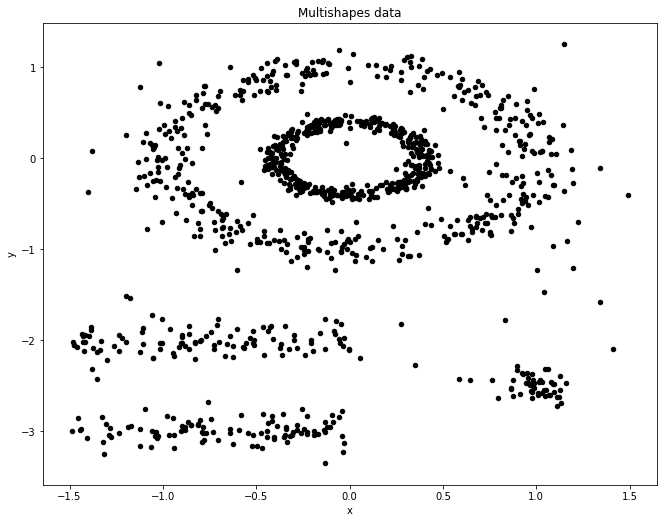

In [6]:
scaled_df.plot.scatter(x='x',y='y',c='Black',title="Multishapes data",figsize=(11,8.5));

#### R
We'll work in parallel in R, as some later function work better in that language.

In [7]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

r_scaled_df = pandas2ri.py2ri(scaled_df)

There is an 'automatic' function in rpy2 to convert a pnadas data frame into an R object. However, this function isn't included in the package's documentation, so use it at your own risk.

The old style of building data frames will always work.

In [8]:
r_scaled_df = rpy2.robjects.DataFrame({"x": rpy2.robjects.FloatVector(scaled_df['x']), 
                                  "y": rpy2.robjects.FloatVector(scaled_df['y'])
                                 })
r_scaled_df

x,y
-0.803739,-0.853053
0.852851,0.367618
0.927180,-0.274902
-0.752626,-0.511565
...,...
0.930758,-2.366531
0.989555,-2.475225
0.979200,-2.637578
1.121931,-2.619054


<div class="discussion"><b>Discussion</b></div>

- Above, we named a data frame 'scaled', but didn't actually scale it! When we're clustering should we scale or not?

## Kmeans

We kick things off with the old workhorse of clustering: KMeans. The "who cares, it runs" code is below, but first a small conceptual digression on how/why Kmeans does[n't] work: http://web.stanford.edu/class/ee103/visualizations/kmeans/kmeans.html

Lessons:
 - Initializations matter; run multiple times
 - Total Squared dsitance should never get worse during an update
 - KMeans can struggle with clusters that are close together; they can get lumped into one
 - There's no notion of 'not part of any cluster' or 'part of two clusters'

#### Python

In [9]:
from sklearn.cluster import KMeans

fitted_km = KMeans(n_clusters=5, init='random', n_init=5, random_state=109).fit(scaled_df)

display(fitted_km.cluster_centers_)
display(fitted_km.labels_[0:10])

array([[-0.35981394, -0.49384068],
       [-0.71581926, -2.48493748],
       [ 0.97688793, -2.38945886],
       [-0.28306103,  0.5234012 ],
       [ 0.58969517, -0.07953374]])

array([0, 4, 4, 0, 4, 4, 3, 0, 0, 0])

Above, we see two useful components of the kmeans fit: the coordinates of the 5 cluster centers, and the clusters assigned to (the first few) points of data 

#### R

In R, Kmeans is part of the 'stats' library, so we first `importr` 'stats', then call the `.kmeans` function within that grouping. As always, we refer to R's documentation to figure out the name of the function and its arguments. [Link to the documentation](https://www.rdocumentation.org/packages/stats/versions/3.5.2/topics/kmeans)

We also set R's random number generator, which allows us to get exatcly reproducible results.

In [10]:
r_base = importr('base')
r_base.set_seed(109) #set seed for random number generation

r_stats = importr('stats')
r_km_out = r_stats.kmeans(scaled_df, 5, nstart=5)

display(r_km_out)
display(list(r_km_out.names))
display(r_km_out.rx2("size"))

R object with classes: ('kmeans',) mapped to:
<ListVector - Python:0x000001B7B59C0948 / R:0x000001B7B8016118>
[IntVector, Matrix, FloatVector, FloatVector, ..., FloatVector, IntVector, IntVector, IntVector]
  cluster: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x000001B7B59C0DC8 / R:0x000001B7B82D4198>
[4, 3, 3, 4, ..., 2, 2, 2, 2]
  centers: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x000001B7B4B1C548 / R:0x000001B7B80163D8>
[-0.275288, 0.976888, 0.590826, -0.361774, ..., -2.389459, -0.084235, -0.491818, -2.484937]
  totss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000001B7B59C0788 / R:0x000001B7B82DEF30>
[1977.496339]
  withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000001B7B59C0D48 / R:0x000001B7B80E5B18>
[63.860029, 8.135006, 78.448034, 67.410601, 93.841392]
  tot.withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000001B7B5991548 / R:0x000001B7B82950D0>
[311.695061]
  betweenss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000001B7B59915C8 / R:0x000001B7B82DEEF8>
[1665.801278]
  size: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x000001B7B59912C8 / R:0x000001B7B811BA60>
[261, 60, 294, 275, 210]
  iter: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x000001B7B59C0D48 / R:0x000001B7B82951E8>
[3]
  ifault: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x000001B7B59C0788 / R:0x000001B7B82952C8>
[0]

['cluster',
 'centers',
 'totss',
 'withinss',
 'tot.withinss',
 'betweenss',
 'size',
 'iter',
 'ifault']

261,60,294,275,210


Recall that R functions typically return something between a named list and a dictionary. You can display it directly, and access particular segments via `.rx2()`

## Plotting

#### Python
As of 2019, python doesn't have many specialized plotting methods, you mostly have to do it yourself. Take note of matplotlib's `c=` argument to color items in a plot, and stacking two different plotting functions in the same cell.

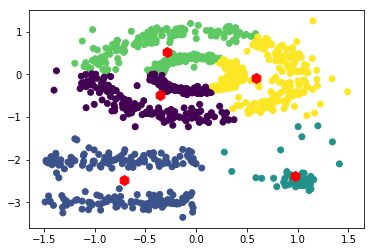

In [11]:
plt.scatter(scaled_df['x'],scaled_df['y'], c=fitted_km.labels_);
plt.scatter(fitted_km.cluster_centers_[:,0],fitted_km.cluster_centers_[:,1], c='r', marker='h', s=100); 

#### R
As before, R is loaded with custom plotting. We're upgrading how we call R for plotting-- once you `%load_ext rpy2.ipython` (once per notebook, like `%matplotlib inline`) use %R to run a single line of R code, or %%R to run a whole cell of R code. Transfer R objects from python to r by adding `-i` and the object name on the %%R line.

Summary:
 - `%load_ext rpy2.ipython` once
 - `%%R` when you want to run multiple lines of R code
     - Won't send outputs back into python
     - Will display plots in the notebook
 - Move robject variables to R via `-i`

In [12]:
%load_ext rpy2.ipython

C:\Users\Will\Anaconda3\envs\109b\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


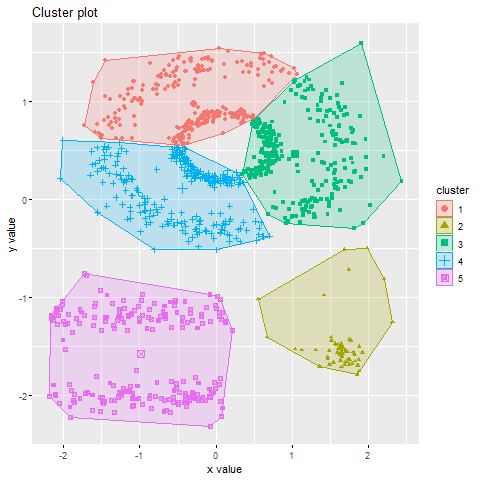

In [13]:
%%R -i r_km_out -i r_scaled_df
library(factoextra)
fviz_cluster(r_km_out, r_scaled_df, geom = "point")

## Selecting size: Elbow
This method measures the total (squared) distance from points to their cluster's centroid. Within a given cluster, this is *equivalent*, up to a factor of $2n$, to the summed (squared) distance from each point to the other points in the cluster (the phrasing we use in laer methods). Look for the place(s) where distance stops decreasing as much.

#### Python

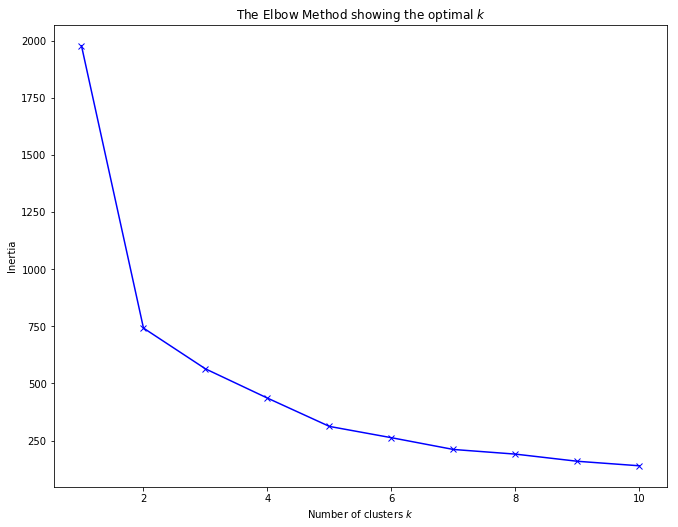

In [14]:
wss = []
for i in range(1,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(scaled_df)
    wss.append(fitx.inertia_)

plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), wss, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

#### R
Nearly all of our plots in R today come from the handy library `factoextra` (and nearly all of our plots will be from the `fviz_clust` function). Becuase we ran `library(factoextra)` in R earlier, the library is still loaded and we can invoke fviz_clust directly. Also, the `-i` is optional: R remembers what r_scaled_df is from before, but it can be wise to always send over the latest version.

Summary:
 - R remembers things you've loaded, saved, or passed it before, just like variables persist across cells in jupyter
 - `library(factoextra)` and then `fviz_nbclust` is your main plotting tool
 - Remember to set `nstart=` above its default of 1 whenever you use Kmeans in R
 - Documentation [here](https://www.rdocumentation.org/packages/factoextra/versions/1.0.5/topics/fviz_nbclust)

C:\Users\Will\Anaconda3\envs\109b\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


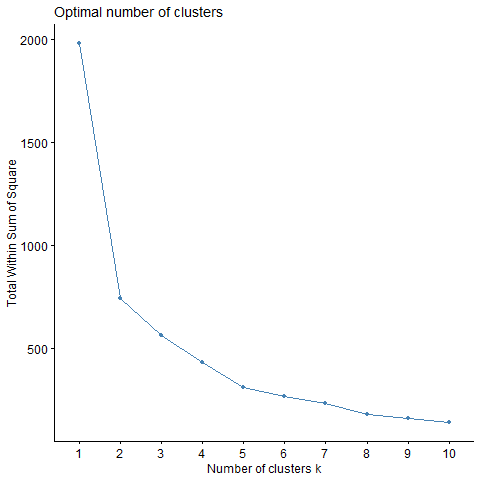

In [15]:
%%R -i r_scaled_df
fviz_nbclust(r_scaled_df, kmeans, method="wss", nstart = 5)

## Selecting size: Silhouette
Silhouette scores measure how close an observation is (on average) to points in its cluster, compared to the next-closest cluster's points. The range is [-1,1]; 0 indicates a point on the decision boundary (equal average closeness to points in both clusters), and negative values mean that datum might be better in a different cluster.

The silhouette score plotted below is the average of the above score across all points.

#### Python
The silhouette score is a metric available in sklearn. We have to manually loop over values of K, calculate, and plot.

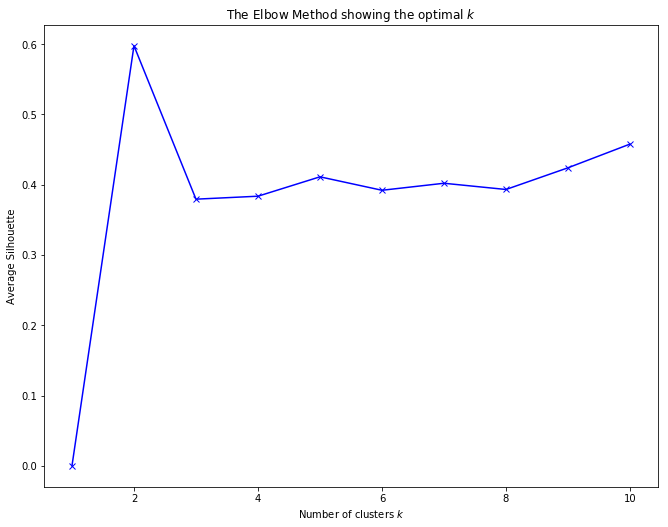

In [16]:
from sklearn.metrics import silhouette_score

scores = [0]
for i in range(2,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(scaled_df)
    score = silhouette_score(scaled_df, fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

#### R
Again, `fviz_clust` will do the work, we just need to pass it a different `method=`.

C:\Users\Will\Anaconda3\envs\109b\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


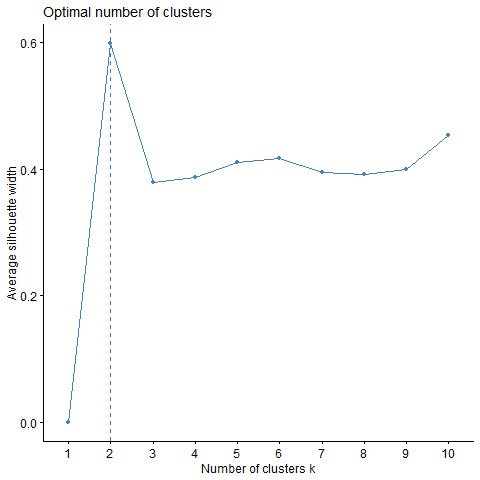

In [17]:
%%R -i r_scaled_df
fviz_nbclust(r_scaled_df, kmeans, method="silhouette", nstart = 5)

## Selecting size: Gap Statistic
The gap statistic compares within-cluster distances (like in silhouette), but instead of comparing against the second-best existing cluster for that point, it compares our clustering's overall average to average we'd see when data don't have clusters at all.

In essence, the within-cluster distances (in the elbow plot) will go down just becuse we have more clusters. We additionally calculate how much they'd go down on non-clustered data with the same spread as our data and subtract that trend out to produce the plot below.

#### Python
Again, we'd have to code it up ourselves. Though there are some implementations online, they're not ready for immediate use.

In [18]:
# you'd have to implement it yourself

#### R
And again, `fviz_clust` will do the work, we just need to pass it a different `method=`.

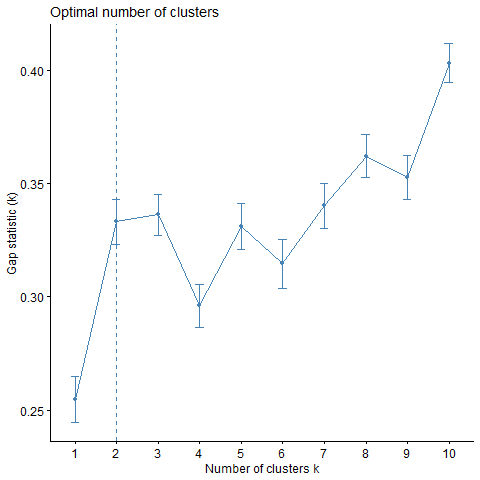

In [19]:
%%R -i r_scaled_df
fviz_nbclust(r_scaled_df, kmeans, method="gap", nstart = 5)

<div class="exercise"><b>Exercise 1</b></div>

- Determine the optimal number of clusters
- Re-fit a KNN model with that number of clusters

In [20]:
#your code here.

## Asessing Fit: Silhouette

#### Python
Below, we borrow from an SKlearn example. The second plot may be overkill.
 - The second plot is JUST the first two dimensions in the data. It is *not* a PCA plot
 - If you only need the raw silhouette scores, use the `silhouette_samples` function

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, clusterer, pointlabels=None):
    cluster_labels = clusterer.labels_
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 5, the average silhouette_score is 0.41118597712860394.


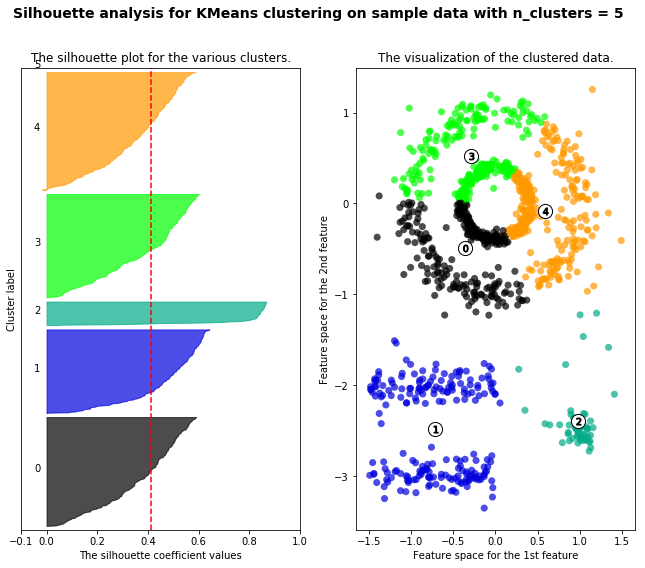

In [22]:
silplot(scaled_df.values, fitted_km)

#### R
To get the plot in R, we need to jump through a few hoops
 - import the `cluster` library (once)
 - call the `silhouette` function on cluster assignments and the inter-point distances
 - call `fviz_silhouette` on the result
 
Luckily, we can run multiple lines of R at a time

C:\Users\Will\Anaconda3\envs\109b\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


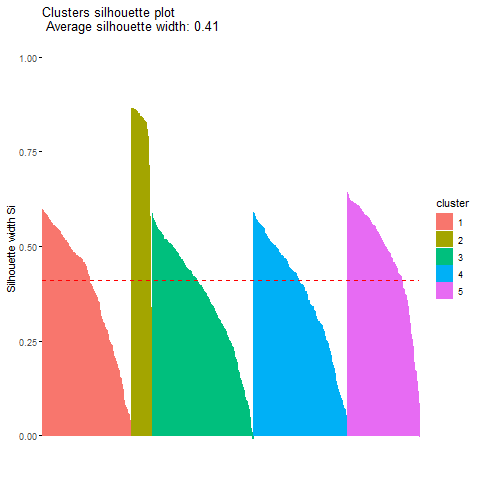

In [23]:
%%R -i r_km_out -i r_scaled_df
library(cluster)
sil = silhouette(r_km_out$cluster, dist(r_scaled_df))
fviz_silhouette(sil)

<div class="exercise"><b>Exercise 2</b></div>
 
 - Display the silhouette plots for your own model

<div class="discussion"><b>Discussion</b></div>

- How do we know which of two silhouette plots is better?

In [24]:
#your code here

## Algomerative
Aglomerative clustering merges clusters together from the bottom up. There are many possible rules about which cluster(s) to combine next. Ward's rule wants to have the lowest possible total within-cluster distance, so it merges the two clusters that will harm this objective least.

#### Python
Scipy has Ward's method implemented, though the call sequence is a little convoluted, and the code is slow.

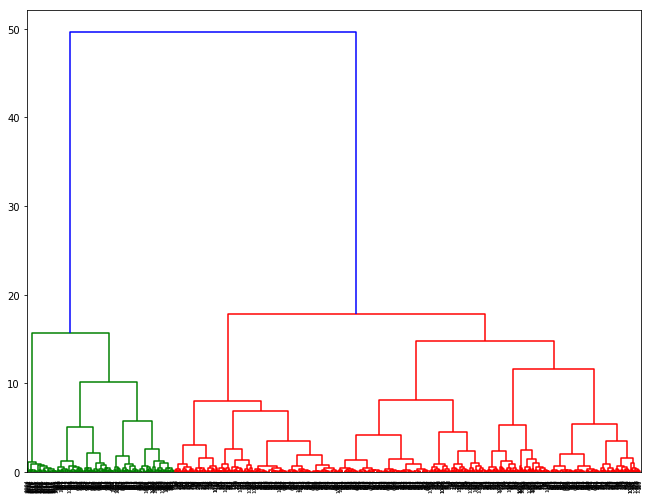

In [25]:
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

plt.figure(figsize=(11,8.5))
dist_mat = pdist(scaled_df, metric="euclidean")
ward_data = hac.ward(dist_mat)

hac.dendrogram(ward_data);

#### R
R's code runs much faster, and the code is cleaner. Note that hclust is from the `cluster` library and you'd need to import it if you haven't already.

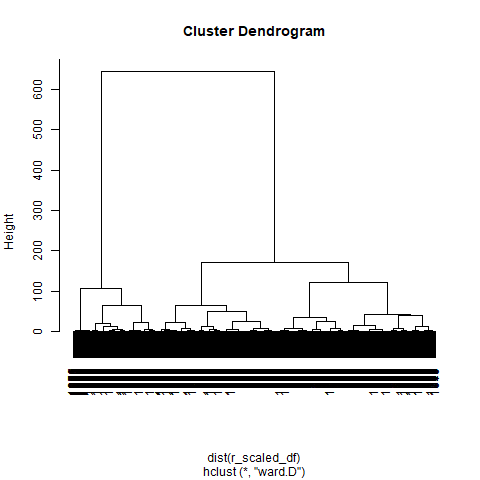

In [26]:
%%R -i r_scaled_df
stacked_cluster = hclust(dist(r_scaled_df), method = "ward.D")
plot(stacked_cluster)

<div class="discussion"><b>Discussion</b></div>

- How do you read a plot like the above? What are valid options for number of clusters, and how can you tell? Are some more valid than others?

## DBscan
DBscan is one of many alternative clustering algorithms, that uses an intuitive notion of denseness to define clusters, rather than defining them by a central point as in Kmeans.

#### Python
DBscan is implemented in good 'ol sklearn, but there aren't great tools for working out the epsilon parameter.

In [27]:
# I couldn't find any easy code for epsilon-tuning plot

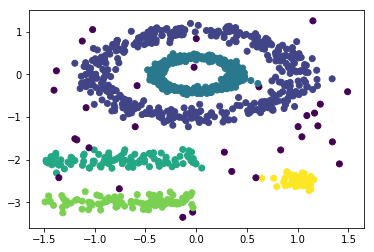

In [28]:
from sklearn.cluster import DBSCAN

fitted_dbscan = DBSCAN(eps=0.15).fit(scaled_df)

plt.scatter(scaled_df['x'],scaled_df['y'], c=fitted_dbscan.labels_);

#### R
R's dbscan is in the `dbscan` library. It comes with `kNNdistplot` for tuning epsilon, and `fviz_cluster` will make a nice plot.

C:\Users\Will\Anaconda3\envs\109b\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


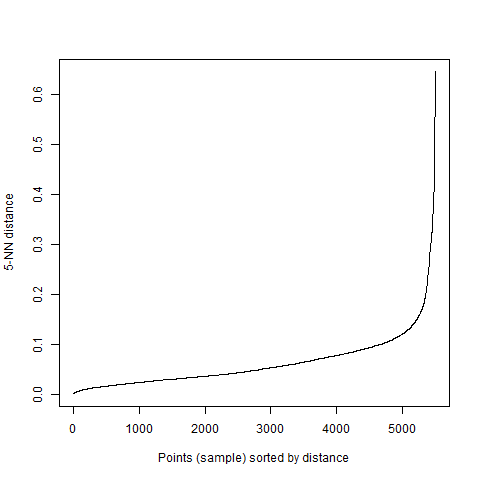

In [29]:
%%R -i r_scaled_df
library(dbscan)
kNNdistplot(r_scaled_df,k=5)

Remember, we can import and run functions like dbscan within Python

In [30]:
r_dbscan = importr("dbscan")

r_db_out = r_dbscan.dbscan(r_scaled_df, eps=0.15, minPts = 5)

Or run directly in R

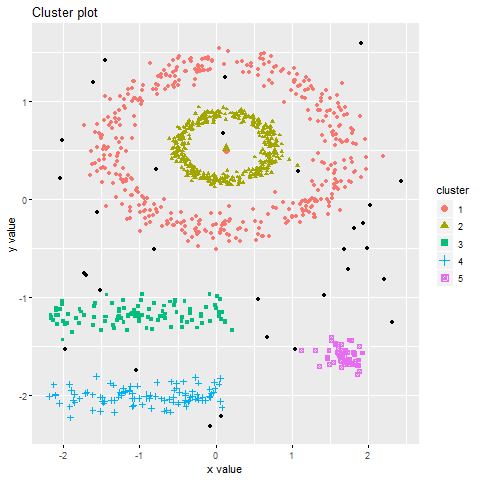

In [31]:
%%R -i r_scaled_df

r_db_out = dbscan(r_scaled_df, eps=0.15, minPts=5)
fviz_cluster(r_db_out, r_scaled_df, ellipse = FALSE, geom = "point")

<div class="exercise"><b>Exercise 3</b></div>
<div class="discussion"><b>Discussion</b></div>

- Use cross validation to select the optimal values of N and epsilon

In [32]:
#your code here?

## Streching: The arrest data and guided practice
In this section you get to transfer the skills and code we learned above to new data.

Because of how much this resembles your individual HW, we'll go over the solutions in lab, but not post them in writing.

As always, we start by loading and exploring the data

In [33]:
arrest_data = pd.read_csv("data/USArrests.csv")
arrest_data['A'] = arrest_data['A'].astype('float64')
arrest_data['UrbanPop'] = arrest_data['UrbanPop'].astype('float64')
arrest_data.head()

,State,M,A,UrbanPop,R
0,Alabama,13.2,236.0,58.0,21.2
1,Alaska,10.0,263.0,48.0,44.5
2,Arizona,8.1,294.0,80.0,31.0
3,Arkansas,8.8,190.0,50.0,19.5
4,California,9.0,276.0,91.0,40.6


<div class="exercise"><b>Exercise</b></div>
 
 - Scale the data
 
 
<div class="discussion"><b>Discussion</b></div>
 
 - Or don't

In [34]:
#your code here

<div class="exercise"><b>Exercise</b></div>

 - Convert the pandas dataframe to R

In [35]:
#your code here

<div class="exercise"><b>Exercise</b></div>

- How many [KMeans] clusters do the 50 states fall into?
- Remember: we've seen three different methods for determining number of clusters

In [36]:
#your code here

In [37]:
#your code here

In [38]:
#your code here

<div class="exercise"><b>Exercise</b></div>

- Fit a k-means cclustering with the number of clusters you think is best

In [39]:
#your code here

<div class="exercise"><b>Exercise</b></div>

 - How good is your clustering?

In [40]:
#your code here

<div class="exercise"><b>Exercise</b></div>

 - Run an aglomerative clustering. 
 - What's the benefit of this method? How many clusters does it suggest?

In [41]:
#your code here

<div class="exercise"><b>Exercise</b></div>

 - Run dbscan on this data. Remember to tune epsilon.
 - How well does it perform?

In [42]:
#your code here

<div class="discussion"><b>Discussion</b></div>

- How did you synthsize the different suggestions for number of clusters?
- What method, and  what clustering seems correct?
- Why is clustering useful?

## Bonus: A Hint About Why Clustering The States Is Hard

In [43]:
numeric_cols = ['M','A','UrbanPop','R']
pca = PCA()
scaled_df = pd.DataFrame(StandardScaler().fit_transform(arrest_data[numeric_cols]),
                         columns = arrest_data[numeric_cols].columns,
                         index = arrest_data.index) 
pca_df = pca.fit_transform(scaled_df)

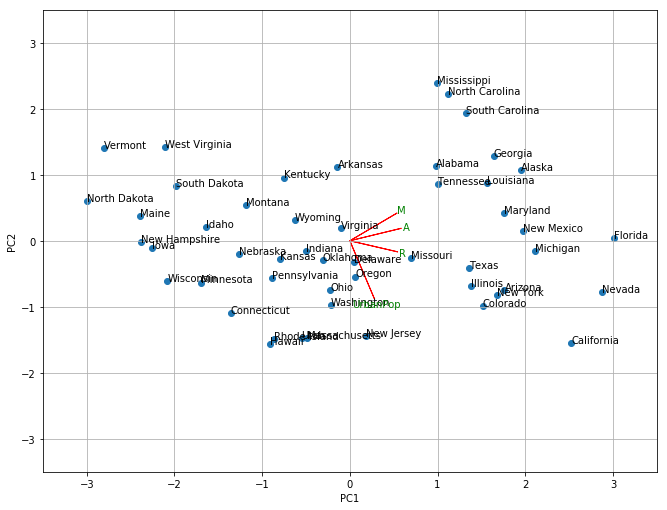

In [44]:
def biplot(scaled_data, fitted_pca, axis_labels, point_labels):
    
    pca_results = fitted_pca.transform(scaled_data)
    pca1_scores = pca_results[:,0]
    pca2_scores = pca_results[:,1]
    
    # plot each point in 2D post-PCA space
    plt.scatter(pca1_scores,pca2_scores)
    
    # label each point
    for i in range(len(pca1_scores)):
        plt.text(pca1_scores[i],pca2_scores[i], point_labels[i])
    
    #for each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0,i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1,i]
        plt.arrow(0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2 ,color = 'r',alpha = 1)
        plt.text(raw_dims_delta_on_pca1*1.1, raw_dims_delta_on_pca2*1.1, axis_labels[i], color = 'g', ha = 'center', va = 'center')

plt.figure(figsize=(11,8.5))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
biplot(scaled_df, pca, axis_labels=scaled_df.columns, point_labels=arrest_data['State'])